#### Importiamo le librerie necessarie. Useremo ResNet50.

In [1]:
from tensorflow import keras
import numpy as np
import tarfile
from time import time
from tensorflow.keras.applications import resnet50
import matplotlib.pyplot as plt
import pandas as pd
import datetime, os
import pathlib
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import inception_v3
from IPython import display

# Load the TensorBoard notebook extension
%load_ext tensorboard

## Creiamo train e test set

## Prima configurazione

In [2]:
train_dir = "data/dataset/mel_final/train" 
val_dir = "data/dataset/mel_final/val"
test_dir = "data/dataset/mel_final/test"

In [3]:
species = np.array(tf.io.gfile.listdir(str(train_dir)))
species = species[species != 'README.md']
n_classes= len(species)
print('Commands:', species)

Commands: ['Alces_alces' 'Bos_taurus' 'Cervus_elaphus' 'Equus_caballus'
 'Lutra_lutra' 'Ovis' 'Pan' 'Panthera_leo' 'Procyon' 'Vulpes']


In [4]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= resnet50.preprocess_input)
                                                                #shear_range=0.2,
                                                                #zoom_range=0.2,
                                                                #horizontal_flip=True,
                                                                #rotation_range=20,
                                                                #width_shift_range=0.2,
                                                                #height_shift_range=0.2,
                                                                #brightness_range=[0.5, 1.5])


train_generator = train_processing.flow_from_directory(directory = train_dir,
                                    target_size = (224, 75),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1234)

Found 561 images belonging to 10 classes.


#### Ora andiamo a definire il test generator, in cui non applicheremo alcun tipo di data agumentation ovviamente, in quanto i dati di test devono essere utilizzati come sono.

In [5]:
val_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

val_generator = val_processing.flow_from_directory(
        directory=val_dir,
        target_size=(224, 75),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 90 images belonging to 10 classes.


In [6]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet50.preprocess_input)

test_generator = test_processing.flow_from_directory(
        directory=test_dir,
        target_size=(224, 75),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 108 images belonging to 10 classes.


#### Importiamo il modello con i pesi adatti (imagenet), e settiamo i layer iniziali come non allenabili

In [7]:
base_net = resnet50.ResNet50(weights="imagenet", include_top=False,
	input_shape=(224, 75, 3), pooling="avg")

In [8]:
for layer in base_net.layers:
    layer.trainable = False

#### Ora aggiungiamo due fully connected layers e poi creiamo un nuovo modello "net", dato dalla combinazione dei due 

In [9]:
# Output of the base_net model
x = base_net.output
# intermediate fully-connected layer + ReLU
x = keras.layers.Dense(1024, activation='relu')(x)
# final fully-connected layer + SoftMax 
pred = keras.layers.Dense(n_classes, activation='softmax')(x)

In [10]:
net1 = keras.Model(inputs=base_net.input, outputs=pred)

In [11]:
net1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 75, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 81, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 38, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 38, 64)  256         conv1_conv[0][0]                 
_______________________________________________________________________________________

#### Compiliamo il modello usando come loss la categorical crossentropy, come optimizer RMSprop e come metrica l'accuracy

In [12]:
net1.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

#### Ora fittiamo il modello con 10 epoche e visualizziamo i risultati in termini di accuracy e loss su train e test set

In [13]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [14]:
history1 = net1.fit(train_generator,
          epochs=10,
          validation_data=val_generator,
          callbacks=[tensorboard_callback])

Epoch 1/10
 1/18 [>.............................] - ETA: 0s - loss: 2.3355 - accuracy: 0.2500WARNING:tensorflow:From C:\Users\feder\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
18/18 [==============================] - 24s 1s/step - loss: 2.8637 - accuracy: 0.2317 - val_loss: 1.6884 - val_accuracy: 0.4667
Epoch 2/10
18/18 [==============================] - 22s 1s/step - loss: 1.5286 - accuracy: 0.5134 - val_loss: 1.2231 - val_accuracy: 0.6556
Epoch 3/10
18/18 [==============================] - 22s 1s/step - loss: 1.2159 - accuracy: 0.5954 - val_loss: 1.0861 - val_accuracy: 0.6111
Epoch 4/10
18/18 [==============================] - 23s 1s/step - loss: 1.0079 - accuracy: 0.6667 - val_loss: 1.0276 - val_accuracy: 0.6111
Epoch 5/10
18/18 [==============================] - 24s 1s/step - loss: 0.85

In [15]:
#Open tensorboard
#Open localhost:6006

In [16]:
def accuracy_loss(history):
    plt.figure(figsize=(20,10))
    #
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label = "train_accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="train_accuracy", color ="blue")
    plt.legend(loc='best', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15)
    #
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Test loss", color = "blue")
    plt.legend(loc='best', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15)

In [17]:
performance1 = net1.evaluate(test_generator)

4/4 [==============================] - 4s 1s/step - loss: 0.8303 - accuracy: 0.7315


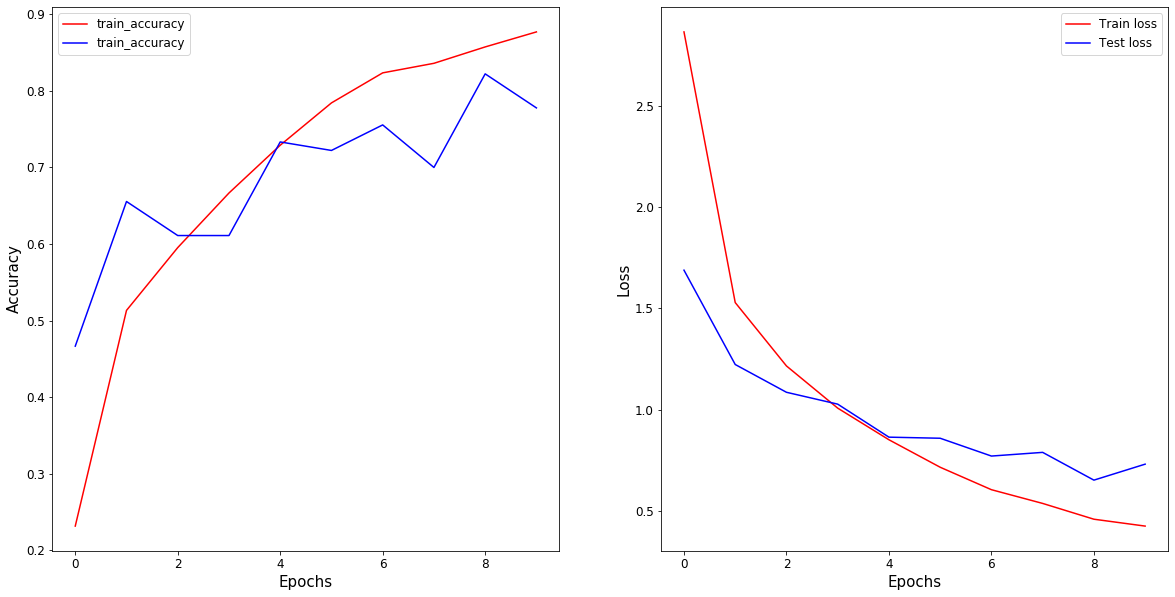

In [18]:
accuracy_loss(history1)